In [295]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import streamlit as st
from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
from scipy.stats import norm
from datetime import datetime, timedelta
import random

from ab_testing.constants import client_name, target_col
from ab_testing.data_acquisition.acquire_data import queries_dict  # AcquireData
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

In [10]:
A = pd.DataFrame({'meta_date': ['2023-01-05', '2023-01-05', '2023-01-06', '2023-01-06', '2023-01-07',  '2023-01-07', '2023-01-08', '2023-01-08'],
                'test_variant': ['P', 'C', 'P', 'C', 'P', 'C', 'P', 'C'],
                'num_of_users': [98525, 228559, 102345, 233458, 99642, 230040, 96235, 231504],
                'num_of_spenders': [4137, 10158, 4324, 9826, 3987, 9964, 4251, 10264],
                'sum_of_logs_spend': [8249.71, 20291.64, 8543.29, 21487.15, 7925.37, 20330.48, 8152.93, 19471.16],
                'sum_of_squared_logs_spend': [16499.42, 40583.28, 17215.43, 42855.78, 15782.45, 40548.21, 16879.96, 41986.35,]})

In [16]:
A

meta_date test_variant  num_of_users  num_of_spenders  sum_of_logs_spend  \
0  2023-01-05            P         98525             4137            8249.71   
1  2023-01-05            C        228559            10158           20291.64   
2  2023-01-06            P        102345             4324            8543.29   
3  2023-01-06            C        233458             9826           21487.15   
4  2023-01-07            P         99642             3987            7925.37   
5  2023-01-07            C        230040             9964           20330.48   
6  2023-01-08            P         96235             4251            8152.93   
7  2023-01-08            C        231504            10264           19471.16   

   sum_of_squared_logs_spend  
0                   16499.42  
1                   40583.28  
2                   17215.43  
3                   42855.78  
4                   15782.45  
5                   40548.21  
6                   16879.96  
7                   41986.35

In [57]:
A = pd.DataFrame({'meta_date': ['2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
                'inputs dictionary with priors and input data values': ['{ \'priors_C\' : {...},  \'priors_P\' : {...}, \'input_data_values_C\' : {...},   \'input_data_values_P\' : {...}}', '{ \'priors_C\' : {...},  \'priors_P\' : {...}, \'input_data_values_C\' : {...},   \'input_data_values_P\' : {...}}', '{ \'priors_C\' : {...},  \'priors_P\' : {...}, \'input_data_values_C\' : {...},   \'input_data_values_P\' : {...}}','{ \'priors_C\' : {...},  \'priors_P\' : {...}, \'input_data_values_C\' : {...},   \'input_data_values_P\' : {...}}'],
                'posterior_a_beta_C': [0, 0, 0, 0],
                'posterior_a_beta_P': [0, 0, 0, 0],
                '...': ['...', '...', '...', '...'],
                'posterior_w_C': [0, 0, 0, 0],
                'posterior_w_P': [0, 0, 0, 0],
                'probab_of_P_better_than_C': [0, 0, 0, 0],
                'probab_of_C_better_than_P': [0, 0, 0, 0],
                'expected_loss_C': [0, 0, 0, 0],
                'expected_loss_P': [0, 0, 0, 0],
                'expected_total_gain_C': [0, 0, 0, 0],
                'expected_total_gain_P': [0, 0, 0, 0]})

In [58]:
A

meta_date inputs dictionary with priors and input data values  \
0  2023-01-05  { 'priors_C' : {...},  'priors_P' : {...}, 'in...    
1  2023-01-06  { 'priors_C' : {...},  'priors_P' : {...}, 'in...    
2  2023-01-07  { 'priors_C' : {...},  'priors_P' : {...}, 'in...    
3  2023-01-08  { 'priors_C' : {...},  'priors_P' : {...}, 'in...    

   posterior_a_beta_C  posterior_a_beta_P  ...  posterior_w_C  posterior_w_P  \
0                   0                   0  ...              0              0   
1                   0                   0  ...              0              0   
2                   0                   0  ...              0              0   
3                   0                   0  ...              0              0   

   probab_of_P_better_than_C  probab_of_C_better_than_P  expected_loss_C  \
0                          0                          0                0   
1                          0                          0                0   
2                          0                          0                0   
3                          0                          0                0   

   expected_loss_P  expected_total_gain_C  expected_total_gain_P  
0                0                      0                      0  
1                0                      0                      0  
2                0                      0                      0  
3                0                      0                      0

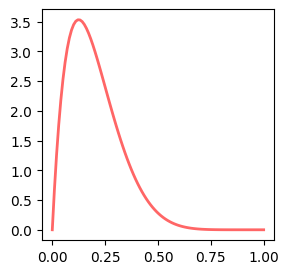

In [59]:
a_prior_beta = 2
b_prior_beta = 8
fig, ax = plt.subplots(figsize=(3, 3))
x = np.linspace(0, 1, 100)
ax.plot(
        x,
        scipy.stats.beta.pdf(x, a_prior_beta, b_prior_beta),
        "r-",
        lw=2,
        alpha=0.6,
        label="norm pdf",
    )

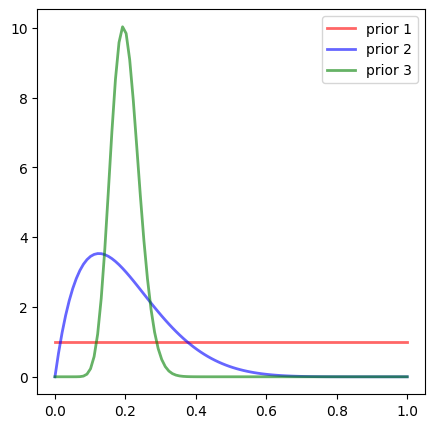

In [127]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 1, 1),
        "r-",
        lw=2,
        alpha=0.6,
        label="prior 1",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 2, 8),
        "b-",
        lw=2,
        alpha=0.6,
        label="prior 2",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 20, 80),
        "g-",
        lw=2,
        alpha=0.6,
        label="prior 3",
    )
ax.legend()

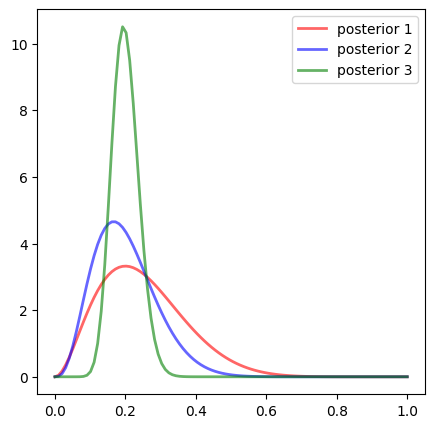

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 3, 9),
        "r-",
        lw=2,
        alpha=0.6,
        label="posterior 1",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 4, 16),
        "b-",
        lw=2,
        alpha=0.6,
        label="posterior 2",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 22, 88),
        "g-",
        lw=2,
        alpha=0.6,
        label="posterior 3",
    )
ax.legend()

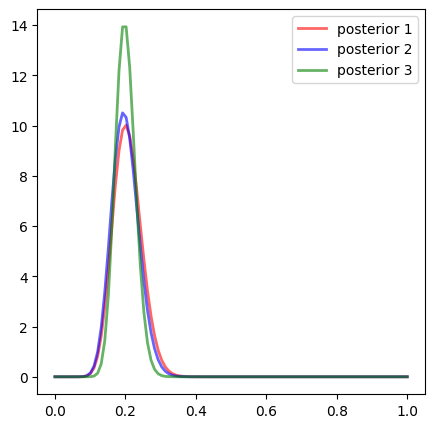

In [135]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 21, 81),
        "r-",
        lw=2,
        alpha=0.6,
        label="posterior 1",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 22, 88),
        "b-",
        lw=2,
        alpha=0.6,
        label="posterior 2",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 40, 160),
        "g-",
        lw=2,
        alpha=0.6,
        label="posterior 3",
    )
ax.legend()

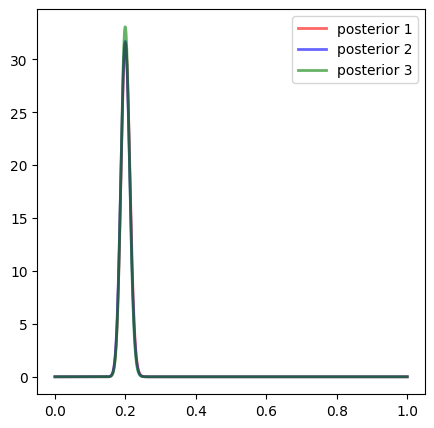

In [137]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 1000)
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 201, 801),
        "r-",
        lw=2,
        alpha=0.6,
        label="posterior 1",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 202, 808),
        "b-",
        lw=2,
        alpha=0.6,
        label="posterior 2",
    )
ax.plot(
        x,
        scipy.stats.beta.pdf(x, 220, 880),
        "g-",
        lw=2,
        alpha=0.6,
        label="posterior 3",
    )
ax.legend()

In [86]:
from typing import List, Tuple, Union
def estimate_probabilities(data: Union[List[List[float]], np.ndarray]) -> List[float]:
    """
    Estimate probabilities for variants considering simulated data from respective posteriors.

    Parameters
    ----------
    data : List of simulated data for each variant.

    Returns
    -------
    res : List of probabilities of being best for each variant.
    """
    max_values = np.argmax(data, axis=0)
    unique, counts = np.unique(max_values, return_counts=True)
    occurrences = dict(zip(unique, counts))
    sim_count = len(data[0])
    res = []
    for i in range(len(data)):
        res.append(round(occurrences.get(i, 0) / sim_count, 7))
    return res

In [89]:
def estimate_expected_loss(data: Union[List[List[float]], np.ndarray]) -> List[float]:
    """
    Estimate expected losses for variants considering simulated data from respective posteriors.

    Parameters
    ----------
    data : List of simulated data for each variant.

    Returns
    -------
    res : List of expected loss for each variant.
    """
    max_values = np.max(data, axis=0)
    res = list(np.mean(max_values - data, axis=1).round(7))
    return res

In [91]:
# TODO: For now this only works for the case of two variants and not more
def estimate_expected_total_gain(
    data: Union[List[List[float]], np.ndarray]
) -> List[float]:
    """
    Estimate expected total gain for variants considering simulated data from respective posteriors.

    Parameters
    ----------
    data : List of simulated data for each variant.

    Returns
    -------
    res : List of expected total gains for each variant.
    """
    # pdb.set_trace()
    res = list(np.mean(data - data[[1, 0], :], axis=1).round(7))
    return res

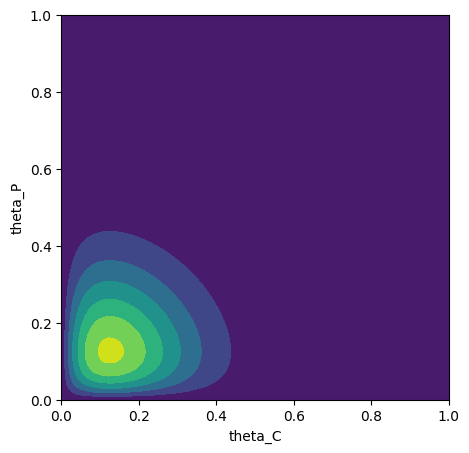

[0.4934, 0.5066]
[0.0675105, 0.0671119]
[-0.0003987, 0.0003987]


In [92]:
a_beta_C = 2 
b_beta_C = 8

a_beta_P = 2 
b_beta_P = 8
x_vector = np.linspace(0,1,100,)

z_pdf = np.zeros((100, 100))
for i, x in enumerate(x_vector):
    for j, y in enumerate(x_vector):
        z_pdf[i, j] = scipy.stats.beta.pdf(x, a_beta_C, b_beta_C) * scipy.stats.beta.pdf(y, a_beta_P, b_beta_P)

fig, ax = plt.subplots(figsize=(5, 5))
X, Y = np.meshgrid(x_vector, x_vector)
ax.contourf(X, Y, np.transpose(z_pdf))
ax.set_xlabel("theta_C")
ax.set_ylabel("theta_P")
plt.show()

beta_samples_C = np.random.beta(a_beta_C,
                b_beta_C,
                20000,
            )
beta_samples_P = np.random.beta(a_beta_P,
                b_beta_P,
                20000,
            )
samples = np.array([beta_samples_C, beta_samples_P])
print(estimate_probabilities(samples))
print(estimate_expected_loss(samples))
print(estimate_expected_total_gain(samples))

In [82]:
beta_samples_C

array([0.31990479, 0.31632766, 0.11843111, ..., 0.09570549, 0.26832457,
       0.02258176])

In [103]:
def plot_contour_plot_and_compute_results(a_beta_C, b_beta_C, a_beta_P, b_beta_P):
    x_vector = np.linspace(0,1,100,)

    z_pdf = np.zeros((100, 100))
    for i, x in enumerate(x_vector):
        for j, y in enumerate(x_vector):
            z_pdf[i, j] = scipy.stats.beta.pdf(x, a_beta_C, b_beta_C) * scipy.stats.beta.pdf(y, a_beta_P, b_beta_P)

    fig, ax = plt.subplots(figsize=(5, 5))
    X, Y = np.meshgrid(x_vector, x_vector)
    ax.contourf(X, Y, np.transpose(z_pdf))
    ax.set_xlabel("theta_C")
    ax.set_ylabel("theta_P")
    plt.show()
    
    beta_samples_C = np.random.beta(a_beta_C,
                    b_beta_C,
                    200000,
                )
    beta_samples_P = np.random.beta(a_beta_P,
                    b_beta_P,
                    200000,
                )
    samples = np.array([beta_samples_C, beta_samples_P])
    print(estimate_probabilities(samples))
    print(estimate_expected_loss(samples))
    print(estimate_expected_total_gain(samples))

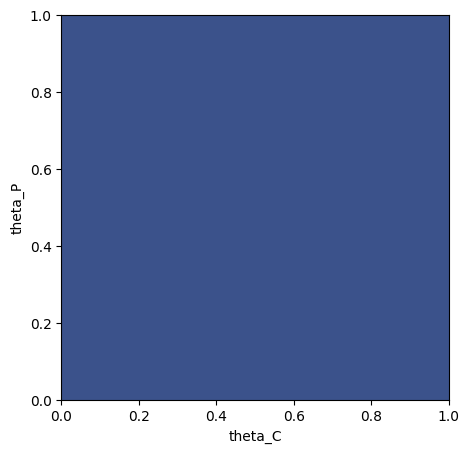

[0.499005, 0.500995]
[0.1661598, 0.1664046]
[0.0002448, -0.0002448]


In [107]:
plot_contour_plot_and_compute_results(1, 1, 1, 1)

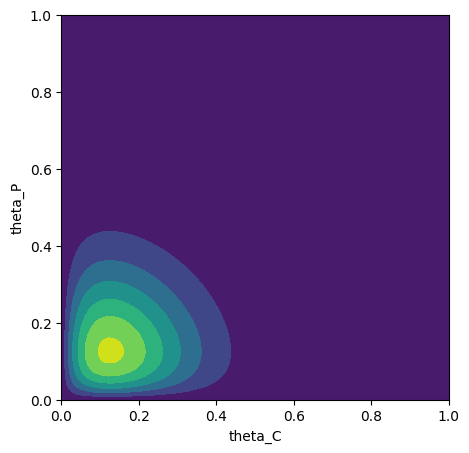

[0.500565, 0.499435]
[0.0665993, 0.0669139]
[0.0003146, -0.0003146]


In [104]:
plot_contour_plot_and_compute_results(2, 8, 2, 8)

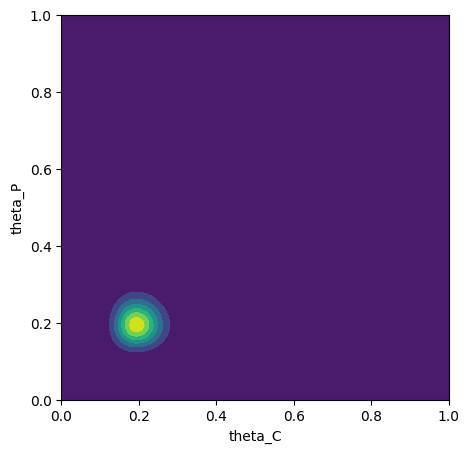

[0.49943, 0.50057]
[0.0224326, 0.0223986]
[-3.4e-05, 3.4e-05]


In [106]:
plot_contour_plot_and_compute_results(20, 80, 20, 80)

# Add 10 datapoints with two conversions to each variant

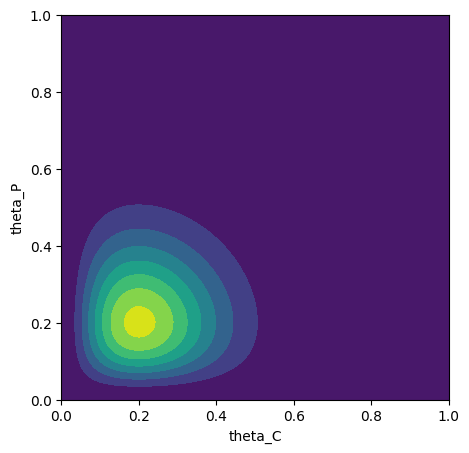

[0.499915, 0.500085]
[0.0673823, 0.0673232]
[-5.91e-05, 5.91e-05]


In [108]:
plot_contour_plot_and_compute_results(3, 9, 3, 9)

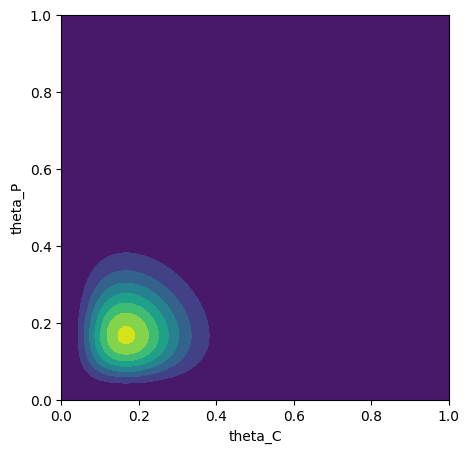

[0.499725, 0.500275]
[0.0488318, 0.0488539]
[2.22e-05, -2.22e-05]


In [109]:
plot_contour_plot_and_compute_results(4, 16, 4, 16)

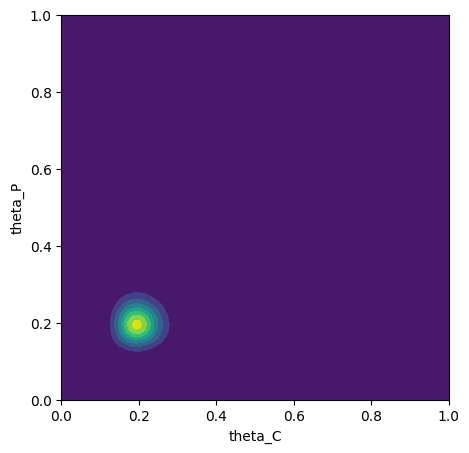

[0.49986, 0.50014]
[0.021379, 0.021422]
[4.3e-05, -4.3e-05]


In [110]:
plot_contour_plot_and_compute_results(22, 88, 22, 88)

# Add 100 datapoints with 20 conversions to each variant

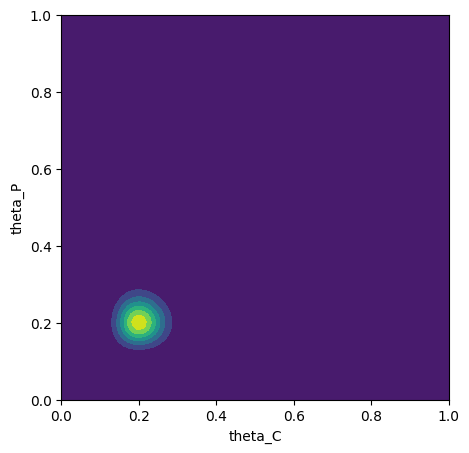

[0.501365, 0.498635]
[0.0223519, 0.022539]
[0.0001871, -0.0001871]


In [111]:
plot_contour_plot_and_compute_results(21, 81, 21, 81)

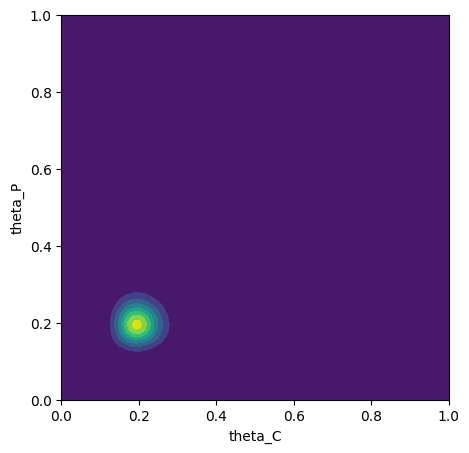

[0.50179, 0.49821]
[0.0212591, 0.0213385]
[7.94e-05, -7.94e-05]


In [112]:
plot_contour_plot_and_compute_results(22, 88, 22, 88)

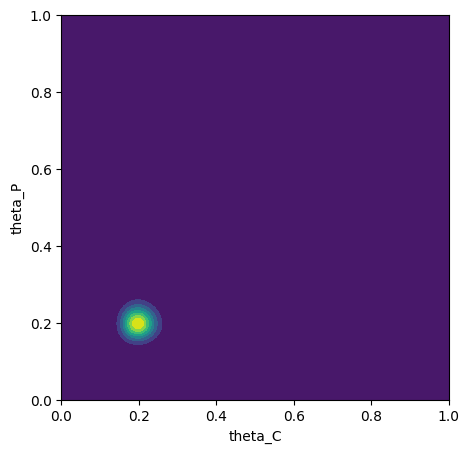

[0.49806, 0.50194]
[0.0159425, 0.0157793]
[-0.0001632, 0.0001632]


In [113]:
plot_contour_plot_and_compute_results(40, 160, 40, 160)

# Add 1000 datapoints with 200 conversions to each variant

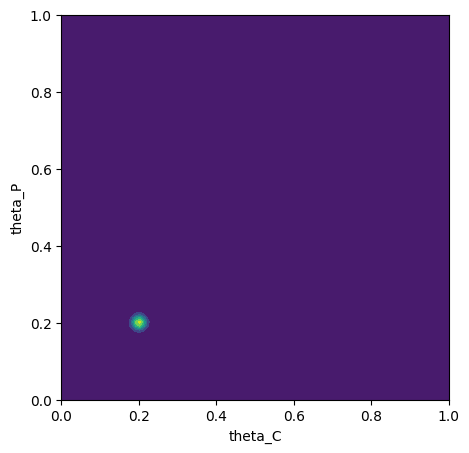

[0.497115, 0.502885]
[0.007166, 0.0070738]
[-9.23e-05, 9.23e-05]


In [114]:
plot_contour_plot_and_compute_results(201, 801, 201, 801)

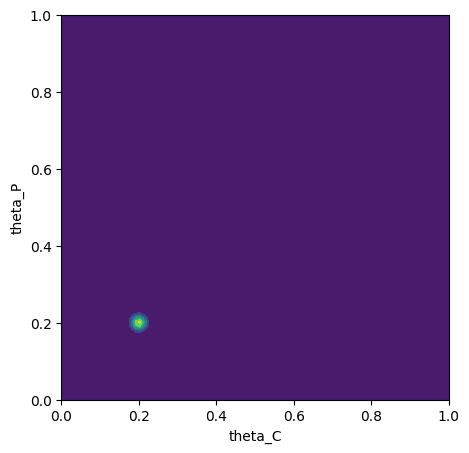

[0.499225, 0.500775]
[0.0071354, 0.0070945]
[-4.09e-05, 4.09e-05]


In [115]:
plot_contour_plot_and_compute_results(202, 808, 202, 808)

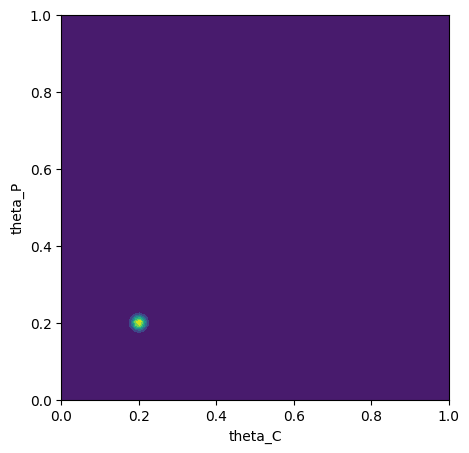

[0.50056, 0.49944]
[0.0067638, 0.0067877]
[2.39e-05, -2.39e-05]


In [116]:
plot_contour_plot_and_compute_results(220, 880, 220, 880)

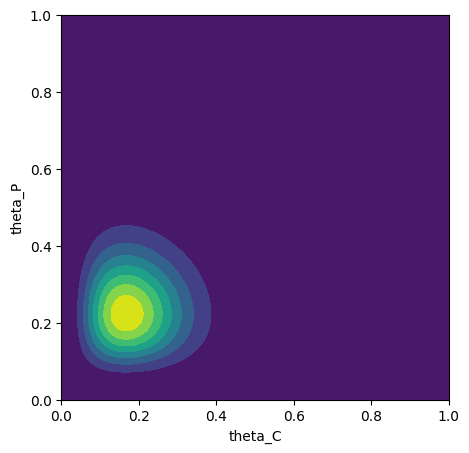

[0.34265, 0.65735]
[0.0803748, 0.0300211]
[-0.0503537, 0.0503537]


In [99]:
plot_contour_plot_and_compute_results(4, 16, 5, 15)

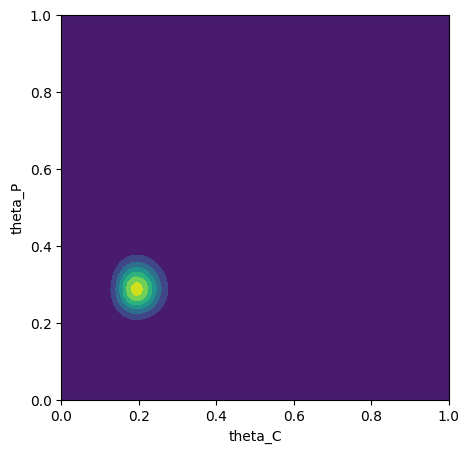

[0.0585, 0.9415]
[0.0921951, 0.0014501]
[-0.090745, 0.090745]


In [100]:
plot_contour_plot_and_compute_results(22, 88, 32, 78)

In [140]:
def estimate_expected_loss(data: Union[List[List[float]], np.ndarray]) -> List[float]:
    """
    Estimate expected losses for variants considering simulated data from respective posteriors.

    Parameters
    ----------
    data : List of simulated data for each variant.

    Returns
    -------
    res : List of expected loss for each variant.
    """
    max_values = np.max(data, axis=0)
    res = list(np.mean(max_values - data, axis=1).round(7))
    return res

In [144]:
A = np.random.beta(2,4,1000)
B = np.random.beta(1,9,1000)

In [147]:
estimate_expected_loss([A,B])

[0.008145, 0.2420851]

In [148]:
def estimate_expected_gain(data: Union[List[List[float]], np.ndarray]) -> List[float]:
    """
    Estimate expected losses for variants considering simulated data from respective posteriors.

    Parameters
    ----------
    data : List of simulated data for each variant.

    Returns
    -------
    res : List of expected loss for each variant.
    """
    min_values = np.min(data, axis=0)
    res = list(np.mean(data-min_values, axis=1).round(7))
    return res

In [149]:
estimate_expected_gain([A,B])

[0.2420851, 0.008145]

In [150]:
import plotly.express as px
df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

In [151]:
df

country continent  year  lifeExp       pop   gdpPercap iso_alpha  \
0     Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG   
1     Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG   
2     Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG   
3     Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG   
4     Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG   
...           ...       ...   ...      ...       ...         ...       ...   
1699     Zimbabwe    Africa  1987   62.351   9216418  706.157306       ZWE   
1700     Zimbabwe    Africa  1992   60.377  10704340  693.420786       ZWE   
1701     Zimbabwe    Africa  1997   46.809  11404948  792.449960       ZWE   
1702     Zimbabwe    Africa  2002   39.989  11926563  672.038623       ZWE   
1703     Zimbabwe    Africa  2007   43.487  12311143  469.709298       ZWE   

      iso_num  
0           4  
1           4  
2           4  
3           4  
4           4  
...       ...  
1699      716  
1700      716  
1701      716  
1702      716  
1703      716  

[1704 rows x 8 columns]

In [20]:
df_mine

meta_date                                             inputs  \
0  2023-01-01  {'a_prior_beta_variant_1': 1, 'a_prior_beta_va...   
1  2023-01-02  {'a_prior_beta_variant_1': 1301, 'a_prior_beta...   
2  2023-01-03  {'a_prior_beta_variant_1': 2339, 'a_prior_beta...   
3  2023-01-04  {'a_prior_beta_variant_1': 3263, 'a_prior_beta...   
4  2023-01-05  {'a_prior_beta_variant_1': 4210, 'a_prior_beta...   
5  2023-01-06  {'a_prior_beta_variant_1': 5184, 'a_prior_beta...   
6  2023-01-07  {'a_prior_beta_variant_1': 6311, 'a_prior_beta...   
7  2023-01-08  {'a_prior_beta_variant_1': 7483, 'a_prior_beta...   
8  2023-01-09  {'a_prior_beta_variant_1': 8638, 'a_prior_beta...   
9  2023-01-10  {'a_prior_beta_variant_1': 9550, 'a_prior_beta...   
10 2023-01-11  {'a_prior_beta_variant_1': 10519, 'a_prior_bet...   
11 2023-01-12  {'a_prior_beta_variant_1': 11573, 'a_prior_bet...   
12 2023-01-13  {'a_prior_beta_variant_1': 12568, 'a_prior_bet...   
13 2023-01-14  {'a_prior_beta_variant_1': 13651, 'a_prior_bet...   
14 2023-01-15  {'a_prior_beta_variant_1': 14736, 'a_prior_bet...   

    a_post_beta_variant_1  a_post_beta_variant_2  b_post_beta_variant_1  \
0                    1301                   2877                  24785   
1                    2339                   5450                  50757   
2                    3263                   7667                  76759   
3                    4210                   9852                 102472   
4                    5184                  12318                 128074   
5                    6311                  15007                 153214   
6                    7483                  17710                 178592   
7                    8638                  20474                 204643   
8                    9550                  22658                 230288   
9                   10519                  24968                 255789   
10                  11573                  27554                 281149   
11                  12568                  29962                 306614   
12                  13651                  32451                 332027   
13                  14736                  35087                 357540   
14                  15769                  37506                 383714   

    b_post_beta_variant_2  m_post_variant_1  m_post_variant_2  \
0                   57669          2.262678          2.336842   
1                  118275          2.195206          2.235687   
2                  178678          2.157058          2.184361   
3                  238859          2.141318          2.162199   
4                  298015          2.142367          2.153821   
5                  356204          2.145316          2.144447   
6                  415124          2.132341          2.132145   
7                  475414          2.130674          2.129434   
8                  535095          2.120562          2.122339   
9                  594596          2.110698          2.112779   
10                 653747          2.114474          2.113252   
11                 713139          2.114634          2.114547   
12                 772439          2.112813          2.110089   
13                 831544          2.104630          2.106442   
14                 892190          2.097915          2.099737   

    a_post_ig_variant_1  a_post_ig_variant_2  b_post_ig_variant_1  \
0                 650.0               1438.0           884.110334   
1                1169.0               2724.5          1596.766757   
2                1631.0               3833.0          2223.673837   
3                2104.5               4925.5          2881.283149   
4                2591.5               6158.5          3549.284191   
5                3155.0               7503.0          4278.029890   
6                3741.0               8854.5          5028.367224   
7                4318.5              10236.5          5814.912692   
8                4774.5              11328.5        

In [11]:
df_mine = pd.read_parquet('temp_results_df')

In [12]:
type(df_mine.meta_date.min())

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
import altair as alt

In [22]:
full_df = pd.DataFrame(columns = ['x', 'y', 'meta_date'])

for current_date in df_mine.meta_date.unique():
    print(current_date)
    a_param_beta = df_mine[df_mine.meta_date == current_date].a_post_beta_variant_1.values[0]
    b_param_beta = df_mine[df_mine.meta_date == current_date].b_post_beta_variant_1.values[0]

    x = np.linspace(
        scipy.stats.beta.ppf(
            0.01,
            a_param_beta,
            b_param_beta,
        ),
        scipy.stats.beta.ppf(
            0.99,
            a_param_beta,
            b_param_beta,
        ),
        100,
    )
    # x = np.linspace(0,1,100,
    # )
   
    y = scipy.stats.beta.pdf(x, a_param_beta, b_param_beta)
    temp_df = pd.DataFrame({'x': x, 'y': y})
    temp_df['meta_date'] = current_date

    full_df = pd.concat([full_df, temp_df])

2023-01-01T00:00:00.000000000
2023-01-02T00:00:00.000000000
2023-01-03T00:00:00.000000000
2023-01-04T00:00:00.000000000
2023-01-05T00:00:00.000000000
2023-01-06T00:00:00.000000000
2023-01-07T00:00:00.000000000
2023-01-08T00:00:00.000000000
2023-01-09T00:00:00.000000000
2023-01-10T00:00:00.000000000
2023-01-11T00:00:00.000000000
2023-01-12T00:00:00.000000000
2023-01-13T00:00:00.000000000
2023-01-14T00:00:00.000000000
2023-01-15T00:00:00.000000000


In [25]:
alt.Chart(full_df[full_df.meta_date == datetime(2023,1,1)]).mark_line().encode(x = 'x', y = 'y', color = 'meta_date').interactive()

alt.Chart(...)

In [61]:
# slider = alt.binding_range(min=0, max=100, step=1, name='cutoff:')
# selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
#                                 bind=slider, init={'cutoff': 50})
from datetime import datetime
def timestamp(t):
  return pd.to_datetime(t).timestamp() * 1000

slider = alt.binding_range(name='cutoff:', min=timestamp("2023-01-01"), max=timestamp("2023-01-10"))
selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
                            bind=slider,init={"cutoff": timestamp("2020-05-05")})
alt.Chart(full_df).mark_line().encode(x = 'x', y = 'y', opacity = 'meta_date').add_selection(
    selector
)

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [65]:
import plotly.express as px
px.scatter(full_df, x="x", y="y", animation_frame="meta_date", animation_group="meta_date",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

KeyError: Timestamp('2023-01-01 00:00:00')

In [62]:
import altair as alt
import pandas as pd
import numpy as np
from datetime import datetime

datelist = pd.date_range(datetime.today(), periods=100).tolist()

rand = np.random.RandomState(42)

df = pd.DataFrame({
    'xval': datelist,
    'yval': rand.randn(100).cumsum(),
})

def timestamp(t):
  return pd.to_datetime(t).timestamp() * 1000

slider = alt.binding_range(name='cutoff:', min=timestamp(min(datelist)), max=timestamp(max(datelist)))
selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
                            bind=slider,init={"cutoff": timestamp("2020-05-05")})

alt.Chart(df).mark_point().encode(
    x='xval',
    y='yval',
    color=alt.condition(
        'toDate(datum.xval) < SelectorName.cutoff[0]',
        alt.value('red'), alt.value('blue')
    )
).add_selection(
    selector
)

alt.Chart(...)

In [6]:
import altair as alt
from vega_datasets import data
import pandas as pd


# Convert date column to an actual date and filter the data.
movies = (
    data.movies()
    .assign(Release_Date=lambda df: pd.to_datetime(df['Release_Date']))
    .query('1960 < Release_Date < 2010')
    .sample(1_000, random_state=90384))

select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='year(Release_Date)',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)))

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [27]:
select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(full_df).mark_bar().encode(
    x='meta_date',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(full_df).mark_line().encode(
    x='x',
    y='y',
    ).interactive()

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [17]:
full_df

x           y  meta_date
0   0.046789   20.591855 2023-01-01
1   0.046852   23.026105 2023-01-01
2   0.046916   25.684209 2023-01-01
3   0.046979   28.578233 2023-01-01
4   0.047042   31.719826 2023-01-01
..       ...         ...        ...
95  0.040136  129.654286 2023-01-15
96  0.040150  117.218765 2023-01-15
97  0.040165  105.749659 2023-01-15
98  0.040179   95.199141 2023-01-15
99  0.040194   85.518474 2023-01-15

[1500 rows x 3 columns]

In [20]:
full_df['meta_date'] = full_df.meta_date.dt.date

In [45]:
results_df = pd.read_parquet('temp_results_df')
results_df_2 = pd.read_parquet('temp_results_df_2')

In [33]:
results_df.to_parquet('fake_ab_testing_results/test_1_results')
results_df_2.to_parquet('fake_ab_testing_results/test_2_results')
results_df.to_parquet('fake_ab_testing_results/test_3_results')
results_df.to_parquet('fake_ab_testing_results/test_4_results')
results_df.to_parquet('fake_ab_testing_results/test_5_results')
results_df.to_parquet('fake_ab_testing_results/test_6_results')
results_df.to_parquet('fake_ab_testing_results/test_7_results')

In [39]:
results_df_2.results[0]

{'expected_loss_version_1': 0.0141309,
 'expected_loss_version_2': 0.0114175,
 'expected_total_gain_version_1': -0.0027134,
 'expected_total_gain_version_2': 0.0027134,
 'prob_being_best_version_1': 0.4533,
 'prob_being_best_version_2': 0.5467}

In [286]:
#results_df.loc[14]['prob_being_best_version_2']
#results_df.loc[14]['expected_loss_version_2']
results_df.loc[14]['expected_total_gain_version_2']

0.0127494

In [288]:
#results_df.loc[14]['prob_being_best_version_2'] - results_df.loc[13]['prob_being_best_version_2']
#results_df.loc[14]['expected_loss_version_2'] - results_df.loc[13]['expected_loss_version_2']
results_df.loc[14]['expected_total_gain_version_2'] - results_df.loc[13]['expected_total_gain_version_2']

-0.003244499999999999

In [287]:
#results_df_2.loc[14]['results']['prob_being_best_version_2']
#results_df_2.loc[14]['results']['expected_loss_version_2']
results_df_2.loc[14]['results']['expected_total_gain_version_2']

0.004267

In [290]:
#results_df_2.loc[14]['results']['prob_being_best_version_1'] - results_df_2.loc[13]['results']['prob_being_best_version_1']
#results_df_2.loc[14]['results']['expected_loss_version_2'] - results_df_2.loc[13]['results']['expected_loss_version_2']
results_df_2.loc[14]['results']['expected_total_gain_version_2'] - results_df_2.loc[13]['results']['expected_total_gain_version_2']

-0.0012158999999999998

In [291]:
all_results_df = pd.DataFrame({'test_name':['test_1', 'test_2', 'test_3', 'test_4', 'test_5', 'test_6', 'test_7'],
                                'expected_loss_version_1': [0.01344, 0.0054527, 0.01344, 0.01344, 0.01344, 0.01344, 0.01344],
                                'expected_loss_delta_version_1': [-0.00299, -0.00098, -0.00299, -0.00299, -0.00299, -0.00299, -0.00299],
                                'expected_loss_version_2': [0.0006907, 0.0011857, 0.0006907, 0.0006907, 0.0006907, 0.0006907, 0.0006907],
                                'expected_loss_delta_version_2': [0.0002527, 0.0002325, 0.0002527, 0.0002527, 0.0002527, 0.0002527, 0.0002527],
                                'expected_total_gain_version_1': [-0.0127494, -0.004267, -0.0127494, -0.0127494, -0.0127494, -0.0127494, -0.0127494],
                                'expected_total_gain_delta_version_1': [0.003244, 0.00122, 0.003244, 0.003244, 0.003244, 0.003244, 0.003244],
                                'expected_total_gain_version_2': [0.0127494, 0.004267, 0.0127494, 0.0127494, 0.0127494, 0.0127494, 0.0127494],
                                'expected_total_gain_delta_version_2': [-0.00324, -0.00122, -0.00324, -0.00324, -0.00324, -0.00324, -0.00324],
                                'prob_being_best_version_1': [0.12685, 0.2702, 0.12685, 0.12685, 0.12685, 0.12685, 0.12685],
                                'prob_being_best_delta_version_1': [0.04310, 0.04835, 0.04310, 0.04310, 0.04310, 0.04310, 0.04310],
                                'prob_being_best_version_2': [0.87315, 0.7298, 0.87315, 0.87315, 0.87315, 0.87315, 0.87315],
                                'prob_being_best_delta_version_2': [-0.04310, -0.04835, -0.04310, -0.04310, -0.04310, -0.04310, -0.04310]})

In [292]:
all_results_df.to_parquet('fake_ab_testing_results/all_results_df')

In [48]:
def unpack_columns_from_dict(df, dict_column_name, new_column_names):

    for new_column_name in new_column_names:
        df[new_column_name] = 0
        for i in range(df.shape[0]):
            df.loc[i, new_column_name] = df.loc[i, dict_column_name][new_column_name]

    return df

In [49]:
results_df = unpack_columns_from_dict(
    results_df,
    "inputs",
    [
        "totals_variant_1",
        "totals_variant_2",
        "positives_variant_1",
        "positives_variant_2",
        "sum_values_variant_1",
        "sum_values_variant_2",
        "sum_logs_variant_1",
        "sum_logs_variant_2",
        "sum_logs_squared_variant_1",
        "sum_logs_squared_variant_2",
        "a_prior_beta_variant_1",
        "a_prior_beta_variant_2",
        "b_prior_beta_variant_1",
        "b_prior_beta_variant_2",
        "m_prior_variant_1",
        "m_prior_variant_2",
        "a_prior_ig_variant_1",
        "a_prior_ig_variant_2",
        "b_prior_ig_variant_1",
        "b_prior_ig_variant_2",
        "w_prior_variant_1",
        "w_prior_variant_2",
    ],
)

results_df = unpack_columns_from_dict(
    results_df,
    "results",
    [
        "prob_being_best_version_1",
        "prob_being_best_version_2",
        "expected_loss_version_1",
        "expected_loss_version_2",
        "expected_total_gain_version_1",
        "expected_total_gain_version_2",
    ],
)

<AxesSubplot: xlabel='meta_date', ylabel='prob_being_best_version_1'>

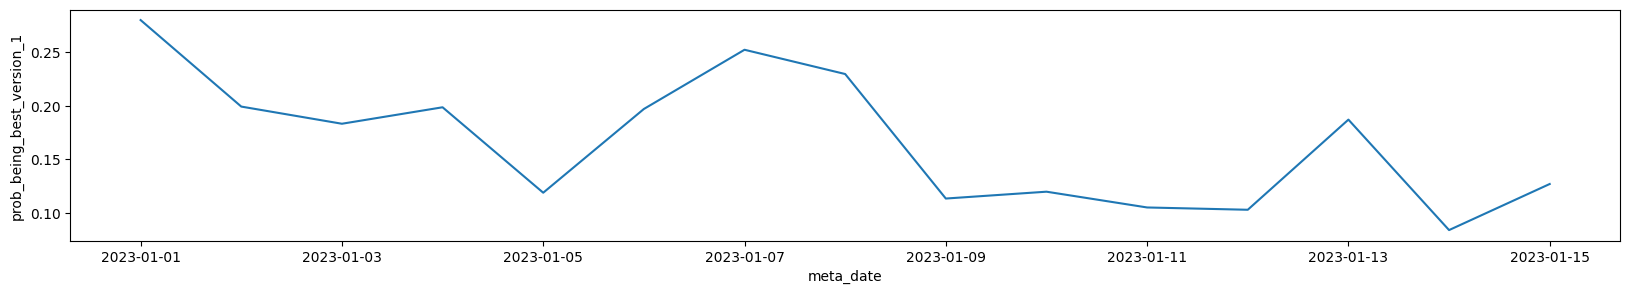

In [50]:
fig, ax = plt.subplots(figsize=(20, 3))
x = np.linspace(0, 1, 100)
sns.lineplot(
            x=results_df.meta_date.dt.date,
            y=results_df.prob_being_best_version_1,
        )

In [68]:
plotting_df = results_df[['meta_date', 'prob_being_best_version_1', 'prob_being_best_version_2']].melt('meta_date', var_name='variant', value_name='probab_being_best')
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['x'], empty='none')

line = alt.Chart(plotting_df).mark_line().encode(x="meta_date:T", y="probab_being_best:Q", color = 'variant:N')

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(plotting_df).mark_point().encode(
    x='x:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'y:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(plotting_df).mark_rule(color='gray').encode(
    x='x:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [52]:
fig

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


ValueError: prob_being_best_version_1' encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

In [107]:
source = plotting_df.copy()
source = source.rename(columns = {'meta_date': 'x', 'variant': 'category', 'probab_being_best': 'y' })
source['category'] = source['category'].apply(lambda x: 'A' if x == 'prob_being_best_version_1' else 'B')
source['x'] = source['x'].dt.day
source

x category        y
0    1        A  0.28015
1    2        A  0.19925
2    3        A  0.18320
3    4        A  0.19860
4    5        A  0.11870
5    6        A  0.19700
6    7        A  0.25240
7    8        A  0.22970
8    9        A  0.11325
9   10        A  0.11965
10  11        A  0.10490
11  12        A  0.10275
12  13        A  0.18705
13  14        A  0.08375
14  15        A  0.12685
15   1        B  0.71985
16   2        B  0.80075
17   3        B  0.81680
18   4        B  0.80140
19   5        B  0.88130
20   6        B  0.80300
21   7        B  0.74760
22   8        B  0.77030
23   9        B  0.88675
24  10        B  0.88035
25  11        B  0.89510
26  12        B  0.89725
27  13        B  0.81295
28  14        B  0.91625
29  15        B  0.87315

In [105]:
source

x category        n
0    1        A  0.28015
1    2        A  0.19925
2    3        A  0.18320
3    4        A  0.19860
4    5        A  0.11870
5    6        A  0.19700
6    7        A  0.25240
7    8        A  0.22970
8    9        A  0.11325
9   10        A  0.11965
10  11        A  0.10490
11  12        A  0.10275
12  13        A  0.18705
13  14        A  0.08375
14  15        A  0.12685
15   1        B  0.71985
16   2        B  0.80075
17   3        B  0.81680
18   4        B  0.80140
19   5        B  0.88130
20   6        B  0.80300
21   7        B  0.74760
22   8        B  0.77030
23   9        B  0.88675
24  10        B  0.88035
25  11        B  0.89510
26  12        B  0.89725
27  13        B  0.81295
28  14        B  0.91625
29  15        B  0.87315

In [103]:
np.random.seed(42)
source = pd.DataFrame(np.cumsum(np.random.randn(100, 3), 0).round(2),
                    columns=['A', 'B', 'C'], index=pd.RangeIndex(100, name='x'))
source = source.reset_index().melt('x', var_name='category', value_name='y')
source

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [116]:
import altair as alt
import pandas as pd
import numpy as np

# np.random.seed(42)
# source = pd.DataFrame(np.cumsum(np.random.randn(100, 3), 0).round(2),
#                     columns=['A', 'B', 'C'], index=pd.RangeIndex(100, name='x'))
# source = source.reset_index().melt('x', var_name='category', value_name='y')

# Create a selection that chooses the nearest point & selects based on x-value

selection = alt.selection_multi(fields=['category'])
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['x'], empty='none')

# The basic line
line = alt.Chart(source).mark_line().encode(
    x='x:Q',
    y='y:Q',
    color='category:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(source).mark_point().encode(
    x='x:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'y:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(color='gray').encode(
    x='x:Q',
).transform_filter(
    nearest
)


# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)



alt.LayerChart(...)

In [118]:
source = results_df[
            ["meta_date", "expected_loss_version_1", "expected_loss_version_2"]
        ].melt("meta_date", var_name="variant", value_name="Expected loss")

source["variant"] = source["variant"].apply(
            lambda x: 'P'
            if x == "expected_loss_version_1"
            else 'C'
        )

selection = alt.selection_multi(fields=["variant"])
nearest = alt.selection(
            type="single",
            nearest=True,
            on="mouseover",
            fields=["meta_date"],
            empty="none",
        )

        # The basic line
line = (
            alt.Chart(source)
            .mark_line()
            .encode(x="meta_date:T", y="Expected loss:Q", color="variant:N")
        )

        # Transparent selectors across the chart. This is what tells us
        # the x-value of the cursor
selectors = (
            alt.Chart(source)
            .mark_point()
            .encode(
                x="meta_date:T",
                opacity=alt.value(0),
            )
            .add_selection(nearest)
        )

        # Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
            opacity=alt.condition(nearest, alt.value(1), alt.value(0))
        )

        # Draw text labels near the points, and highlight based on selection
text = line.mark_text(align="left", dx=5, dy=-5).encode(
            text=alt.condition(nearest, "Expected loss:Q", alt.value(" "))
        )

        # Draw a rule at the location of the selection
rules = (
            alt.Chart(source)
            .mark_rule(color="gray")
            .encode(
                x="meta_date:T",
            )
            .transform_filter(nearest)
        )

        # Put the five layers into a chart and bind the data
alt.layer(line, selectors, points, rules, text).properties(
            width=900, height=300
        )

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [119]:
full_df = pd.DataFrame(columns = ['x', 'y', 'meta_date'])

for current_date in df_mine.meta_date.unique():
    print(current_date)
    a_param_beta = df_mine[df_mine.meta_date == current_date].a_post_beta_variant_1.values[0]
    b_param_beta = df_mine[df_mine.meta_date == current_date].b_post_beta_variant_1.values[0]

    x = np.linspace(
        scipy.stats.beta.ppf(
            0.01,
            a_param_beta,
            b_param_beta,
        ),
        scipy.stats.beta.ppf(
            0.99,
            a_param_beta,
            b_param_beta,
        ),
        100,
    )
    # x = np.linspace(0,1,100,
    # )
   
    y = scipy.stats.beta.pdf(x, a_param_beta, b_param_beta)
    temp_df = pd.DataFrame({'x': x, 'y': y})
    temp_df['meta_date'] = current_date

    full_df = pd.concat([full_df, temp_df])

2023-01-01T00:00:00.000000000
2023-01-02T00:00:00.000000000
2023-01-03T00:00:00.000000000
2023-01-04T00:00:00.000000000
2023-01-05T00:00:00.000000000
2023-01-06T00:00:00.000000000
2023-01-07T00:00:00.000000000
2023-01-08T00:00:00.000000000
2023-01-09T00:00:00.000000000
2023-01-10T00:00:00.000000000
2023-01-11T00:00:00.000000000
2023-01-12T00:00:00.000000000
2023-01-13T00:00:00.000000000
2023-01-14T00:00:00.000000000
2023-01-15T00:00:00.000000000


In [120]:
# slider = alt.binding_range(min=0, max=100, step=1, name='cutoff:')
# selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
#                                 bind=slider, init={'cutoff': 50})
from datetime import datetime
def timestamp(t):
  return pd.to_datetime(t).timestamp() * 1000

slider = alt.binding_range(name='cutoff:', min=timestamp("2023-01-01"), max=timestamp("2023-01-10"))
selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
                            bind=slider,init={"cutoff": timestamp("2020-05-05")})
alt.Chart(full_df).mark_line().encode(x = 'x', y = 'y', opacity = 'meta_date').add_selection(
    selector
)

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [135]:
import altair as alt
from vega_datasets import data
import pandas as pd


# Convert date column to an actual date and filter the data.
movies = (
    data.movies()
    .assign(Release_Date=lambda df: pd.to_datetime(df['Release_Date']))
    .query('1960 < Release_Date < 2010')
    .sample(1_000, random_state=90384))

select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='month(Release_Date)',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)))

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [122]:
movies

Title     US_Gross  Worldwide_Gross  US_DVD_Sales  \
3028             Town & Country    6712451.0       10364769.0           NaN   
704                 Phantasm II    7000000.0        7000000.0           NaN   
7                       Foolish    6026908.0        6026908.0           NaN   
2218             License to Wed   43799818.0       70799818.0    22782913.0   
1804     For Your Consideration    5549923.0        5549923.0           NaN   
...                         ...          ...              ...           ...   
252            Don Juan DeMarco   22032635.0       22032635.0           NaN   
3131  Where the Wild Things Are   77233467.0       99123656.0    27984751.0   
2367                      Mulan  120620254.0      303500000.0           NaN   
106     Bright Lights, Big City   16118077.0       16118077.0           NaN   
1346                       Bolt  114053579.0      313953579.0    82600642.0   

      Production_Budget Release_Date MPAA_Rating  Running_Time_min  \
3028        105000000.0   2001-04-27           R               NaN   
704           3000000.0   1988-07-08        None               NaN   
7             1600000.0   1999-04-09           R               NaN   
2218         35000000.0   2007-07-03          PG              90.0   
1804         12000000.0   2006-11-17       PG-13              86.0   
...                 ...          ...         ...               ...   
252          25000000.0   1995-04-07       PG-13               NaN   
3131        100000000.0   2009-10-16          PG             100.0   
2367         90000000.0   1998-06-19           G              88.0   
106          25000000.0   1988-04-01           R               NaN   
1346        150000000.0   2008-11-21          PG               NaN   

               Distributor                        Source      Major_Genre  \
3028              New Line           Original Screenplay  Romantic Comedy   
704              Universal                          None           Horror   
7                  Artisan           Original Screenplay           Comedy   
2218          Warner Bros.           Original Screenplay  Romantic Comedy   
1804    Warner Independent           Original Screenplay           Comedy   
...                    ...                           ...              ...   
252               New Line           Original Screenplay            Drama   
3131          Warner Bros.     Based on Book/Short Story        Adventure   
2367  Walt Disney Pictures  Traditional/Legend/Fairytale        Adventure   
106         United Artists     Based on Book/Short Story            Drama   
1346  Walt Disney Pictures           Original Screenplay           Comedy   

             Creative_Type           Director  Rotten_Tomatoes_Rating  \
3028  Contemporary Fiction      Peter Chelsom                    13.0   
704                Fantasy               None                    29.0   
7     Contemporary Fiction               None                     NaN   
2218  Contemporary Fiction         Ken Kwapis                     7.0   
1804  Contemporary Fiction  Christopher Guest                    50.0   
...                    ...                ...                     ...   
252   Contemporary Fiction               None                    73.0   
3131               Fantasy        Spike Jonze                    73.0   
2367         Dramatization               None                    86.0   
106   Contemporary Fiction               None                    61.0   
1346          Kids Fiction               None                    88.0   

      IMDB_Rating  IMDB_Votes  
3028          4.4      2889.0  
704           6.3      3781.0  
7             3.8       353.0  
2218          5.1     15422.0  
1804          6.2      7780.0  
...           ...         ...  
252           6.6     20386.0  
3131          7.2     30669.0  
2367          7.2     34256.0  
106           6.8     11929.0  
1346          7.4     32473.0  

[1000 rows x 16 columns]

In [161]:
movies = full_df.copy()
#movies['meta_date'] = movies['meta_date'].dt.day
movies = movies.rename(columns = {'x': 'xko', 'y': 'yko'})

select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='meta_date',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_line().encode(
    x='xko:Q',
    y='yko:Q',
    color = 'meta_date',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.001)))

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [183]:
full_df = pd.DataFrame(columns = ['x', 'y', 'meta_date'])
min_list = []
max_list = []

for current_date in df_mine.meta_date.unique():
    print(current_date)
    a_param_beta = df_mine[df_mine.meta_date == current_date].a_post_beta_variant_1.values[0]
    b_param_beta = df_mine[df_mine.meta_date == current_date].b_post_beta_variant_1.values[0]

    min_boundary = scipy.stats.beta.ppf(
            0.01,
            a_param_beta,
            b_param_beta,
        )
    min_list.append(min_boundary)

    max_boundary = scipy.stats.beta.ppf(
            0.99,
            a_param_beta,
            b_param_beta,
        )
    max_list.append(max_boundary)

    x_middle = np.linspace(min_boundary, max_boundary, 100)
    x_low = np.linspace(0, min_boundary, 1000)
    x_high = np.linspace(max_boundary, 1, 1000)
    x = np.concatenate((x_low, x_middle, x_high))

    
   
    y = scipy.stats.beta.pdf(x, a_param_beta, b_param_beta)
    temp_df = pd.DataFrame({'x': x, 'y': y})
    temp_df['meta_date'] = current_date

    full_df = pd.concat([full_df, temp_df])





movies = full_df.copy()
movies = movies[(movies.x >= min(min_list)) & (movies.x <= max(max_list))]


#movies = movies[(movies.x >= 0.035) & (movies.x <= 0.055)]
#movies['meta_date'] = movies['meta_date'].dt.day
movies = movies.rename(columns = {'x': 'xko', 'y': 'yko'})

select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='meta_date',
    y='count()').properties(height=50).add_selection(select_year)

scatter_plot = alt.Chart(movies).mark_line().encode(
    x='xko:Q',
    y='yko:Q',
    color = 'meta_date',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.001)))

scatter_plot & bar_slider

2023-01-01T00:00:00.000000000
2023-01-02T00:00:00.000000000
2023-01-03T00:00:00.000000000
2023-01-04T00:00:00.000000000
2023-01-05T00:00:00.000000000
2023-01-06T00:00:00.000000000
2023-01-07T00:00:00.000000000
2023-01-08T00:00:00.000000000
2023-01-09T00:00:00.000000000
2023-01-10T00:00:00.000000000
2023-01-11T00:00:00.000000000
2023-01-12T00:00:00.000000000
2023-01-13T00:00:00.000000000
2023-01-14T00:00:00.000000000
2023-01-15T00:00:00.000000000


c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [166]:
movies

xko            yko  meta_date
80   0.037809   8.477353e-19 2023-01-01
81   0.038282   4.503740e-17 2023-01-01
82   0.038755   1.950873e-15 2023-01-01
83   0.039227   6.923268e-14 2023-01-01
84   0.039700   2.022221e-12 2023-01-01
..        ...            ...        ...
197  0.040165   1.057497e+02 2023-01-15
198  0.040179   9.519914e+01 2023-01-15
199  0.040194   8.551847e+01 2023-01-15
200  0.040194   8.551847e+01 2023-01-15
201  0.049889  6.861927e-211 2023-01-15

[1599 rows x 3 columns]

In [159]:
np.concatenate((x_low, x_middle))

array([0.        , 0.00246258, 0.00492516, 0.00738774, 0.00985032,
       0.01231291, 0.01477549, 0.01723807, 0.01970065, 0.02216323,
       0.02462581, 0.02708839, 0.02955097, 0.03201355, 0.03447614,
       0.03693872, 0.0394013 , 0.04186388, 0.04432646, 0.04678904,
       0.04678904, 0.04685238, 0.04691572, 0.04697905, 0.04704239,
       0.04710573, 0.04716907, 0.0472324 , 0.04729574, 0.04735908,
       0.04742242, 0.04748575, 0.04754909, 0.04761243, 0.04767577,
       0.0477391 , 0.04780244, 0.04786578, 0.04792912, 0.04799245,
       0.04805579, 0.04811913, 0.04818247, 0.0482458 , 0.04830914,
       0.04837248, 0.04843581, 0.04849915, 0.04856249, 0.04862583,
       0.04868916, 0.0487525 , 0.04881584, 0.04887918, 0.04894251,
       0.04900585, 0.04906919, 0.04913253, 0.04919586, 0.0492592 ,
       0.04932254, 0.04938588, 0.04944921, 0.04951255, 0.04957589,
       0.04963923, 0.04970256, 0.0497659 , 0.04982924, 0.04989258,
       0.04995591, 0.05001925, 0.05008259, 0.05014593, 0.05020

In [138]:
movies['Release_Date']

3028   2001-04-27
704    1988-07-08
7      1999-04-09
2218   2007-07-03
1804   2006-11-17
          ...    
252    1995-04-07
3131   2009-10-16
2367   1998-06-19
106    1988-04-01
1346   2008-11-21
Name: Release_Date, Length: 1000, dtype: datetime64[ns]

In [137]:
movies.columns

Index(['Title', 'US_Gross', 'Worldwide_Gross', 'US_DVD_Sales',
       'Production_Budget', 'Release_Date', 'MPAA_Rating', 'Running_Time_min',
       'Distributor', 'Source', 'Major_Genre', 'Creative_Type', 'Director',
       'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'IMDB_Votes'],
      dtype='object')

In [192]:
full_df = pd.DataFrame(columns=["x", "y", "meta_date", "variant"])
min_list = []
max_list = []

for current_date in results_df.meta_date.unique():
    print(current_date)
    a_param_beta_1 = results_df[
                results_df.meta_date == current_date
            ].a_post_beta_variant_1.values[0]
    a_param_beta_2 = results_df[
                results_df.meta_date == current_date
            ].a_post_beta_variant_2.values[0]

    b_param_beta_1 = results_df[
                results_df.meta_date == current_date
            ].b_post_beta_variant_1.values[0]
    b_param_beta_2 = results_df[
                results_df.meta_date == current_date
            ].b_post_beta_variant_2.values[0]

    min_boundary_1 = scipy.stats.beta.ppf(
                0.01,
                a_param_beta_1,
                b_param_beta_1,
            )
    min_list.append(min_boundary_1)
    min_boundary_2 = scipy.stats.beta.ppf(
                0.01,
                a_param_beta_2,
                b_param_beta_2,
            )
    min_list.append(min_boundary_2)

    max_boundary_1 = scipy.stats.beta.ppf(
                0.99,
                a_param_beta_1,
                b_param_beta_1,
            )
    max_list.append(max_boundary_1)
    max_boundary_2 = scipy.stats.beta.ppf(
                0.99,
                a_param_beta_2,
                b_param_beta_2,
            )
    max_list.append(max_boundary_2)

for current_date in results_df.meta_date.unique():
    print(current_date)
    a_param_beta = results_df[
                results_df.meta_date == current_date
            ].a_post_beta_variant_1.values[0]
    b_param_beta = results_df[
                results_df.meta_date == current_date
            ].b_post_beta_variant_1.values[0]

    min_boundary = scipy.stats.beta.ppf(
                0.01,
                a_param_beta,
                b_param_beta,
            )

    max_boundary = scipy.stats.beta.ppf(
                0.99,
                a_param_beta,
                b_param_beta,
            )

    diff = max(max_list) - min(min_list)

    x_middle = np.linspace(min_boundary, max_boundary, 50)
    x_low = np.linspace(min(min_list) - diff / 10, min_boundary, 50)
    x_high = np.linspace(max_boundary, max(max_list) + diff / 10, 50)
    x = np.concatenate((x_low, x_middle, x_high))

    y = scipy.stats.beta.pdf(x, a_param_beta, b_param_beta)
    temp_df = pd.DataFrame({"x": x, "y": y})
    temp_df["meta_date"] = current_date
    temp_df["variant"] = "P"

    full_df = pd.concat([full_df, temp_df])

    a_param_beta = results_df[
                results_df.meta_date == current_date
            ].a_post_beta_variant_2.values[0]
    b_param_beta = results_df[
                results_df.meta_date == current_date
            ].b_post_beta_variant_2.values[0]

    min_boundary = scipy.stats.beta.ppf(
                0.01,
                a_param_beta,
                b_param_beta,
            )

    max_boundary = scipy.stats.beta.ppf(
                0.99,
                a_param_beta,
                b_param_beta,
            )

    diff = max(max_list) - min(min_list)

    x_middle = np.linspace(min_boundary, max_boundary, 50)
    x_low = np.linspace(min(min_list) - diff / 10, min_boundary, 50)
    x_high = np.linspace(max_boundary, max(max_list) + diff / 10, 50)
    x = np.concatenate((x_low, x_middle, x_high))

    y = scipy.stats.beta.pdf(x, a_param_beta, b_param_beta)
    temp_df = pd.DataFrame({"x": x, "y": y})
    temp_df["meta_date"] = current_date
    temp_df["variant"] = "C"

    full_df = pd.concat([full_df, temp_df])

movies = full_df.copy()
movies = movies[
            (movies.x >= min(min_list) - diff / 10)
            & (movies.x <= max(max_list) + diff / 10)
        ]

movies = movies.rename(columns={"x": "xko", "y": "yko"})

select_year = alt.selection_interval(encodings=["x"])

bar_slider = (
            alt.Chart(movies)
            .mark_bar()
            .encode(x="meta_date", y="count()")
            .properties(height=50)
            .add_selection(select_year)
        )

scatter_plot = (
            alt.Chart(movies)
            .mark_line()
            .encode(
                x="xko:Q",
                y="yko:Q",
                color="meta_date",
                strokeDash="variant",
                opacity=alt.condition(select_year, alt.value(0.7), alt.value(0.001)),
            )
        )

scatter_plot & bar_slider

2023-01-01T00:00:00.000000000
2023-01-02T00:00:00.000000000
2023-01-03T00:00:00.000000000
2023-01-04T00:00:00.000000000
2023-01-05T00:00:00.000000000
2023-01-06T00:00:00.000000000
2023-01-07T00:00:00.000000000
2023-01-08T00:00:00.000000000
2023-01-09T00:00:00.000000000
2023-01-10T00:00:00.000000000
2023-01-11T00:00:00.000000000
2023-01-12T00:00:00.000000000
2023-01-13T00:00:00.000000000
2023-01-14T00:00:00.000000000
2023-01-15T00:00:00.000000000
2023-01-01T00:00:00.000000000
2023-01-02T00:00:00.000000000
2023-01-03T00:00:00.000000000
2023-01-04T00:00:00.000000000
2023-01-05T00:00:00.000000000
2023-01-06T00:00:00.000000000
2023-01-07T00:00:00.000000000
2023-01-08T00:00:00.000000000
2023-01-09T00:00:00.000000000
2023-01-10T00:00:00.000000000
2023-01-11T00:00:00.000000000
2023-01-12T00:00:00.000000000
2023-01-13T00:00:00.000000000
2023-01-14T00:00:00.000000000
2023-01-15T00:00:00.000000000


c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

### Posterior for the mean of the revenue

In [220]:
from numpy.random import default_rng
full_df = pd.DataFrame(columns=["x", "y", "meta_date", "variant"])

for current_date in results_df.meta_date.unique():
    # SAMPLING THE MARGINAL PRIOR OF THE MEAN OF THE DATA
    # generate the variances
    rng = default_rng(seed=293809384)

    a_param_ig = results_df[
                results_df.meta_date == current_date
            ].a_post_ig_variant_1.values[0]
    b_param_ig = results_df[
                results_df.meta_date == current_date
            ].a_post_ig_variant_1.values[0]

    m_param = results_df[
                results_df.meta_date == current_date
            ].m_post_variant_1.values[0]
    w_param = results_df[
                results_df.meta_date == current_date
            ].w_post_variant_1.values[0]




    sampled_variances = 1 / rng.gamma(a_param_ig, 1 / b_param_ig, 10000)
    sampled_means = []
    # for each variance generate a mean
    for sampled_variance in sampled_variances:
        sampled_means.append(rng.normal(m_param, np.sqrt(sampled_variance / w_param)))

    # compute the means of the lognormal distribution
    sampled_means_of_lognormal = np.exp(sampled_means + sampled_variances / 2)

    # plot
    min_value = np.quantile(sampled_means_of_lognormal, 0.01)
    max_value = np.quantile(sampled_means_of_lognormal, 0.99)
    x = np.linspace(min_value, max_value, 200)

    # y,x = np.histogram(
    #         sampled_means_of_lognormal, density=True, bins=100, range=(min_value, max_value)
    #     )

    fitted_kde = scipy.stats.gaussian_kde(sampled_means_of_lognormal, bw_method=None, weights=None)
    y = fitted_kde.pdf(x)
    #fig, ax = plt.subplots(figsize=(5, 5))

    #ax.hist(
    #        sampled_means_of_lognormal, density=True, bins=100, range=(min_value, max_value)
    #    )

    temp_df = pd.DataFrame({"x": x, "y": y})
    temp_df["meta_date"] = current_date
    temp_df["variant"] = "P"

    full_df = pd.concat([full_df, temp_df])

movies = full_df.copy()
# movies = movies[
#             (movies.x >= min(min_list) - diff / 10)
#             & (movies.x <= max(max_list) + diff / 10)
#         ]

movies = movies.rename(columns={"x": "xko", "y": "yko"})

select_year = alt.selection_interval(encodings=["x"])

bar_slider = (
            alt.Chart(movies)
            .mark_bar()
            .encode(x="meta_date", y="count()")
            .properties(height=50)
            .add_selection(select_year)
        )

scatter_plot = (
            alt.Chart(movies)
            .mark_line()
            .encode(
                x="xko:Q",
                y="yko:Q",
                color="meta_date",
                opacity=alt.condition(select_year, alt.value(0.7), alt.value(0.001)),
            )
        )

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [221]:
from numpy.random import default_rng
full_df = pd.DataFrame(columns=["x", "y", "meta_date", "variant"])

for current_date in results_df.meta_date.unique():
    # SAMPLING THE MARGINAL PRIOR OF THE MEAN OF THE DATA
    # generate the variances
    rng = default_rng(seed=293809384)

    a_param_ig = results_df[
                results_df.meta_date == current_date
            ].a_post_ig_variant_1.values[0]
    b_param_ig = results_df[
                results_df.meta_date == current_date
            ].b_post_ig_variant_1.values[0]

    m_param = results_df[
                results_df.meta_date == current_date
            ].m_post_variant_1.values[0]
    w_param = results_df[
                results_df.meta_date == current_date
            ].w_post_variant_1.values[0]




    sampled_variances = 1 / rng.gamma(a_param_ig, 1 / b_param_ig, 10000)
    sampled_means = []
    # for each variance generate a mean
    for sampled_variance in sampled_variances:
        sampled_means.append(rng.normal(m_param, np.sqrt(sampled_variance / w_param)))

    # compute the means of the lognormal distribution
    sampled_means_of_lognormal = np.exp(sampled_means + sampled_variances / 2)

    # plot
    min_value = np.quantile(sampled_means_of_lognormal, 0.01)
    max_value = np.quantile(sampled_means_of_lognormal, 0.99)
    x = np.linspace(min_value, max_value, 200)

    # y,x = np.histogram(
    #         sampled_means_of_lognormal, density=True, bins=100, range=(min_value, max_value)
    #     )

    fitted_kde = scipy.stats.gaussian_kde(sampled_means_of_lognormal, bw_method=None, weights=None)
    y = fitted_kde.pdf(x)
    #fig, ax = plt.subplots(figsize=(5, 5))

    #ax.hist(
    #        sampled_means_of_lognormal, density=True, bins=100, range=(min_value, max_value)
    #    )

    temp_df = pd.DataFrame({"x": x, "y": y})
    temp_df["meta_date"] = current_date
    temp_df["variant"] = "P"

    full_df = pd.concat([full_df, temp_df])

movies = full_df.copy()
# movies = movies[
#             (movies.x >= min(min_list) - diff / 10)
#             & (movies.x <= max(max_list) + diff / 10)
#         ]

movies = movies.rename(columns={"x": "xko", "y": "yko"})

select_year = alt.selection_interval(encodings=["x"])

bar_slider = (
            alt.Chart(movies)
            .mark_bar()
            .encode(x="meta_date", y="count()")
            .properties(height=50)
            .add_selection(select_year)
        )

scatter_plot = (
            alt.Chart(movies)
            .mark_line()
            .encode(
                x="xko:Q",
                y="yko:Q",
                color="meta_date",
                opacity=alt.condition(select_year, alt.value(0.7), alt.value(0.001)),
            )
        )

scatter_plot & bar_slider

c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [232]:
from numpy.random import default_rng
full_df = pd.DataFrame(columns=["x", "y", "meta_date", "variant"])
variant_names = ['P', 'C']

list_min_values = []
list_max_values = []
fitted_kdes = []
for current_date in results_df.meta_date.unique():
    rng = default_rng(seed=293809384)

    a_params_ig = (results_df[
                results_df.meta_date == current_date
            ].a_post_ig_variant_1.values[0], results_df[
                results_df.meta_date == current_date
            ].a_post_ig_variant_2.values[0])
    b_params_ig = (results_df[
                results_df.meta_date == current_date
            ].b_post_ig_variant_1.values[0], results_df[
                results_df.meta_date == current_date
            ].b_post_ig_variant_2.values[0])

    m_params = (results_df[
                results_df.meta_date == current_date
            ].m_post_variant_1.values[0], results_df[
                results_df.meta_date == current_date
            ].m_post_variant_2.values[0])
    w_params = (results_df[
                results_df.meta_date == current_date
            ].w_post_variant_1.values[0], results_df[
                results_df.meta_date == current_date
            ].w_post_variant_2.values[0])

    fitted_kdes_small = []
    for i in range(2):
        sampled_variances = 1 / rng.gamma(a_params_ig[i], 1 / b_params_ig[i], 10000)
        sampled_means = []
        # for each variance generate a mean
        for sampled_variance in sampled_variances:
            sampled_means.append(rng.normal(m_params[i], np.sqrt(sampled_variance / w_params[i])))

        # compute the means of the lognormal distribution
        sampled_means_of_lognormal = np.exp(sampled_means + sampled_variances / 2)

        # plot
        min_value = np.quantile(sampled_means_of_lognormal, 0.01)
        max_value = np.quantile(sampled_means_of_lognormal, 0.99)

        list_min_values.append(min_value)
        list_max_values.append(max_value)

        fitted_kde = scipy.stats.gaussian_kde(sampled_means_of_lognormal, bw_method=None, weights=None)
        fitted_kdes_small.append(fitted_kde)

    fitted_kdes.append(fitted_kdes_small)


diff = max(list_max_values) - min(list_min_values)

for j, current_date in enumerate(results_df.meta_date.unique()):   
    for i in range(2):
        x = np.linspace(min(list_min_values)-diff/10, max(list_max_values) +diff/10, 100)

        fitted_kde = fitted_kdes[j][i]
        y = fitted_kde.pdf(x)


        temp_df = pd.DataFrame({"x": x, "y": y})
        temp_df["meta_date"] = current_date
        temp_df["variant"] = variant_names[i]

        full_df = pd.concat([full_df, temp_df])

movies = full_df.copy()
# movies = movies[
#             (movies.x >= min(min_list) - diff / 10)
#             & (movies.x <= max(max_list) + diff / 10)
#         ]

movies = movies.rename(columns={"x": "xko", "y": "yko"})

select_year = alt.selection_interval(encodings=["x"])

bar_slider = (
            alt.Chart(movies)
            .mark_bar()
            .encode(x="meta_date", y="count()")
            .properties(height=50)
            .add_selection(select_year)
        )

scatter_plot = (
            alt.Chart(movies)
            .mark_line()
            .encode(
                x="xko:Q",
                y="yko:Q",
                color="meta_date",
                strokeDash="variant",
                opacity=alt.condition(select_year, alt.value(0.7), alt.value(0.001)),
            )
        )

scatter_plot & bar_slider


c:\Users\karol\anaconda3\envs\assetario_ab_testing_3_8_new\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [228]:
full_df

x             y  meta_date variant
0    15.197149  1.952133e-28 2023-01-01       P
1    15.228891  2.706489e-27 2023-01-01       P
2    15.260634  3.524894e-26 2023-01-01       P
3    15.292376  4.312575e-25 2023-01-01       P
4    15.324118  4.956627e-24 2023-01-01       P
..         ...           ...        ...     ...
195  21.386882  0.000000e+00 2023-01-15       P
196  21.418624  0.000000e+00 2023-01-15       P
197  21.450366  0.000000e+00 2023-01-15       P
198  21.482108  0.000000e+00 2023-01-15       P
199  21.513851  0.000000e+00 2023-01-15       P

[3000 rows x 4 columns]

In [233]:
pd.to_datetime(["2023-01-14 1:00", "2023-01-15"]).astype(int) / 1e6

C:\Users\karol\AppData\Local\Temp\ipykernel_36504\4058320640.py:1: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  pd.to_datetime(["2023-01-14 1:00", "2023-01-15"]).astype(int) / 1e6


Float64Index([1673658000000.0, 1673740800000.0], dtype='float64')

In [234]:
pd.to_datetime(["2023-01-14 1:00", "2023-01-15"])

DatetimeIndex(['2023-01-14 01:00:00', '2023-01-15 00:00:00'], dtype='datetime64[ns]', freq=None)

In [237]:
max(results_df.meta_date) - timedelta(1)

Timestamp('2023-01-14 00:00:00')

In [238]:
pd.to_datetime(
                [max(results_df.meta_date) - timedelta(1), max(results_df.meta_date)]
            ).astype(int)/ 1e6

C:\Users\karol\AppData\Local\Temp\ipykernel_36504\636150423.py:1: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  pd.to_datetime(


Float64Index([1673654400000.0, 1673740800000.0], dtype='float64')

In [239]:
        a_beta_variant_1 = results_df[
            results_df.meta_date == max(results_df.meta_date)
        ].a_post_beta_variant_1.values[0]
        b_beta_variant_1 = results_df[
            results_df.meta_date == max(results_df.meta_date)
        ].b_post_beta_variant_1.values[0]

        a_beta_variant_2 = results_df[
            results_df.meta_date == max(results_df.meta_date)
        ].a_post_beta_variant_2.values[0]
        b_beta_variant_2 = results_df[
            results_df.meta_date == max(results_df.meta_date)
        ].b_post_beta_variant_2.values[0]

        min_boundary_1 = scipy.stats.beta.ppf(
            0.05,
            a_beta_variant_1,
            b_beta_variant_1,
        )
        max_boundary_1 = scipy.stats.beta.ppf(
            0.95,
            a_beta_variant_1,
            b_beta_variant_1,
        )
        min_boundary_2 = scipy.stats.beta.ppf(
            0.05,
            a_beta_variant_2,
            b_beta_variant_2,
        )
        max_boundary_2 = scipy.stats.beta.ppf(
            0.95,
            a_beta_variant_2,
            b_beta_variant_2,
        )

        x_middle = np.linspace(min_boundary_1, max_boundary_1, 50)
        x_low = np.linspace(0, min_boundary_1, 50)
        x_high = np.linspace(max_boundary_1, 1, 50)
        x_vector = np.concatenate((x_low, x_middle, x_high))
        x_vector = x_middle

        y_middle = np.linspace(min_boundary_2, max_boundary_2, 50)
        y_low = np.linspace(0, min_boundary_2, 50)
        y_high = np.linspace(max_boundary_2, 1, 50)
        y_vector = np.concatenate((y_low, y_middle, y_high))
        y_vector = y_middle

        z_pdf = np.zeros((len(x_vector), len(y_vector)))
        for i, x in enumerate(x_vector):
            for j, y in enumerate(y_vector):
                z_pdf[i, j] = scipy.stats.beta.pdf(
                    x, a_beta_variant_1, b_beta_variant_1
                ) * scipy.stats.beta.pdf(y, a_beta_variant_2, b_beta_variant_2)


In [256]:
z_pdf[z_pdf>0].shape

(3820,)

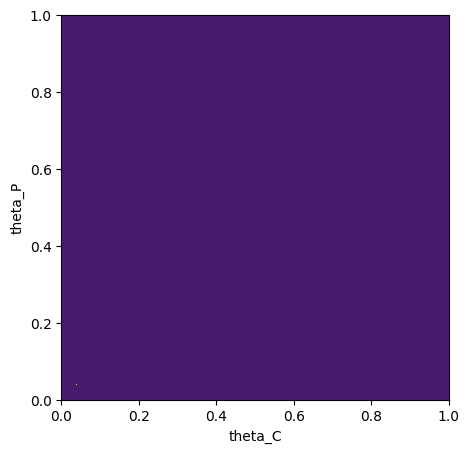

In [258]:
fig, ax = plt.subplots(figsize=(5, 5))
X, Y = np.meshgrid(x_vector, x_vector)
ax.contourf(X, Y, np.transpose(z_pdf))
ax.set_xlabel("theta_C")
ax.set_ylabel("theta_P")
plt.show()

In [251]:
        import plotly.graph_objects as go
        fig = go.Figure(
            data=go.Contour(
                z=z_pdf, x=y_vector, y=x_vector  # horizontal axis  # vertical axis
            )
        )

        fig.update_layout(
            autosize=True,
            width=500,
            height=500,
        )

In [257]:
z_pdf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [242]:
x_vector

array([0.00000000e+00, 7.91024920e-04, 1.58204984e-03, 2.37307476e-03,
       3.16409968e-03, 3.95512460e-03, 4.74614952e-03, 5.53717444e-03,
       6.32819936e-03, 7.11922428e-03, 7.91024920e-03, 8.70127411e-03,
       9.49229903e-03, 1.02833240e-02, 1.10743489e-02, 1.18653738e-02,
       1.26563987e-02, 1.34474236e-02, 1.42384486e-02, 1.50294735e-02,
       1.58204984e-02, 1.66115233e-02, 1.74025482e-02, 1.81935731e-02,
       1.89845981e-02, 1.97756230e-02, 2.05666479e-02, 2.13576728e-02,
       2.21486977e-02, 2.29397227e-02, 2.37307476e-02, 2.45217725e-02,
       2.53127974e-02, 2.61038223e-02, 2.68948473e-02, 2.76858722e-02,
       2.84768971e-02, 2.92679220e-02, 3.00589469e-02, 3.08499719e-02,
       3.16409968e-02, 3.24320217e-02, 3.32230466e-02, 3.40140715e-02,
       3.48050965e-02, 3.55961214e-02, 3.63871463e-02, 3.71781712e-02,
       3.79691961e-02, 3.87602211e-02, 3.87602211e-02, 3.87894737e-02,
       3.88187263e-02, 3.88479789e-02, 3.88772315e-02, 3.89064841e-02,
      

In [243]:
y_vector

array([0.00000000e+00, 8.13652030e-04, 1.62730406e-03, 2.44095609e-03,
       3.25460812e-03, 4.06826015e-03, 4.88191218e-03, 5.69556421e-03,
       6.50921624e-03, 7.32286827e-03, 8.13652030e-03, 8.95017233e-03,
       9.76382436e-03, 1.05774764e-02, 1.13911284e-02, 1.22047805e-02,
       1.30184325e-02, 1.38320845e-02, 1.46457365e-02, 1.54593886e-02,
       1.62730406e-02, 1.70866926e-02, 1.79003447e-02, 1.87139967e-02,
       1.95276487e-02, 2.03413008e-02, 2.11549528e-02, 2.19686048e-02,
       2.27822568e-02, 2.35959089e-02, 2.44095609e-02, 2.52232129e-02,
       2.60368650e-02, 2.68505170e-02, 2.76641690e-02, 2.84778211e-02,
       2.92914731e-02, 3.01051251e-02, 3.09187771e-02, 3.17324292e-02,
       3.25460812e-02, 3.33597332e-02, 3.41733853e-02, 3.49870373e-02,
       3.58006893e-02, 3.66143414e-02, 3.74279934e-02, 3.82416454e-02,
       3.90552974e-02, 3.98689495e-02, 3.98689495e-02, 3.98883260e-02,
       3.99077025e-02, 3.99270790e-02, 3.99464555e-02, 3.99658320e-02,
      

# Queries

In [296]:
configure_offline_feature_store(workgroup="development", catalog_name="production")

In [ ]:
client plus game (a must)
starting date (a must)
whether we look at winsorized or unwinsorized spend
whether we look at personalized or all spend
whether we look at one datapoint per user per meta date or one datapoint per user (with thier first n day spend)
if choosing the second option the n needs to be specified as well


In [297]:
query_bingo_aloha = """
SELECT user_id
     , meta_date
     , first_login
     , CASE
           WHEN group_tag = 'control' THEN 'C'
           WHEN group_tag = 'personalized' THEN 'P'
    END                             test_group
     , COALESCE(SUM(CASE WHEN fl_personalized_offer_spend <> %(spend_type)s THEN spend END), 0)      total_spend
     , COALESCE(SUM(CASE WHEN fl_personalized_offer_spend <> %(spend_type)s THEN wins_spend END), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date   BETWEEN DATE %(strt_date)s AND DATE %(end_date)s
  AND first_login BETWEEN DATE %(strt_fl)s   AND DATE %(end_fl)s
GROUP BY user_id
       , meta_date
       , first_login
       , group_tag;
"""

In [307]:
personalized = True
winsorized = True

if personalized:
    personalized_num = 0
else:
    personalized_num = 9


if winsorized:
    spend_column = 'spend'
else:
    spend_column = 'wins_spend'

In [318]:
company_id = ''
project_id = ''
meta_date = ''
strt_fl = ''
end_fl = ''

In [319]:
data_query = f"""
WITH
    base_table AS (
        SELECT user_id
             , meta_date
             , first_login
             , CASE
                   WHEN group_tag = 'control'      THEN 'C'
                   WHEN group_tag = 'personalized' THEN 'P'
               END                                                                              test_group
             , COALESCE(SUM(CASE WHEN fl_personalized_offer_spend <> {personalized_num} THEN {spend_column} END), 0)      total_spend
        FROM analytics__{company_id}__{project_id}.user_level_performance
        WHERE meta_date = DATE {meta_date}
          AND first_login BETWEEN DATE {strt_fl} AND DATE {end_fl}
        GROUP BY user_id
               , meta_date
               , first_login
               , group_tag
        )

SELECT meta_date
     , test_group
     , COUNT(*)                                              AS totals
     , SUM(CASE WHEN total_spend > 0 THEN 1 ELSE 0 END) AS positives
     , SUM(total_spend) AS sum_values
     , SUM(LN(CASE WHEN total_spend > 0 THEN total_spend END)) AS sum_logs
     , SUM(power(LN(CASE WHEN total_spend > 0 THEN total_spend END), 2.0)) AS sum_logs_squared
FROM base_table
GROUP BY meta_date
       , test_group;"""

In [312]:
start_date = '2022-10-12'
end_date = '2022-12-12'
strt_fl = '2022-10-12'
end_fl = '2022-12-12'

# initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
#         query_bingo_aloha, parameters={'strt_date': start_date, 'end_date': end_date, 'strt_fl': strt_fl, 'end_fl': end_fl, 'spend_type':0}
#     )

initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
         data_query, parameters={'meta_date': start_date, 'strt_fl': strt_fl, 'end_fl': end_fl, 'spend_type':0, 'personalized_num':personalized_num, 'spend_column':spend_column}
    )

2023-02-01 15:15:13,827 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


2023-02-01 15:15:13.827 Found credentials in shared credentials file: ~/.aws/credentials
DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:498.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:4650.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:370575589|c


In [313]:
initial_data

meta_date test_group  totals  positives  sum_values   sum_logs  \
0 2022-10-12          C    4075         19  253.463391  35.139875   
1 2022-10-12          P    1877          7   36.706598   6.284905   

   sum_logs_squared  
0         92.239320  
1         15.421327

In [316]:
company_id = 'tilting-point-mjs4k'
project_id = 'terragenesis-m89uz'
initial_data = FeatureStoreOfflineClient.run_athena_query_pandas(
         data_query, parameters={'meta_date': start_date, 'strt_fl': strt_fl, 'end_fl': end_fl, 'spend_type':0, 'personalized_num':personalized_num, 'spend_column':spend_column}
    )
initial_data

2023-02-01 15:36:53,390 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


2023-02-01 15:36:53.390 Found credentials in shared credentials file: ~/.aws/credentials
DummyStatsClient._send unknown.athena_query_runs_total:1|c


InvalidArgumentValue: Exception parsing query. Root error message: An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 12:32: mismatched input '-'. Expecting: ')', ',', '.', 'AS', 'CROSS', 'EXCEPT', 'FOR', 'FULL', 'GROUP', 'HAVING', 'INNER', 'INTERSECT', 'JOIN', 'LEFT', 'LIMIT', 'NATURAL', 'OFFSET', 'ORDER', 'RIGHT', 'TABLESAMPLE', 'UNION', 'WHERE', <identifier>